# Overview

This notebook calculates and plots: 
* $E_z$ field distribution at time_start and time_end;
* total EM energy evolution in time;
* NCI growth rate, $Im( \omega )/\omega_{p,r}$, calculated between time_start and time_end (within the linear growth of the total energy).


In [1]:
import matplotlib.pyplot as plt
from scipy.constants import c
import numpy as np
import scipy.constants as scc
import yt ; yt.funcs.mylog.setLevel(50)
import glob
%matplotlib inline

# Plot NCI growth rate


In [2]:
path_wx   = 'path to diags folder'

In [3]:
file_list_warpx = glob.glob(path_wx + 'diag1?????')
iterations_warpx = [ int(file_name[len(file_name)-5:]) for file_name in file_list_warpx ]

In [4]:
def calculate_parameters(path):
    iteration=200
    dsx = yt.load( path + 'diag1%05d/' %iteration )
    dxx = dsx.domain_width/dsx.domain_dimensions
    dx=dxx[0];
    dx = 1.*dx.ndarray_view()

    dz=dxx[1];
    
    dz = 1.*dz.ndarray_view()
    cell_volume_x = np.prod(dxx)

    ds1 = yt.load(path+'/diag100100/')
    ds2 = yt.load(path+'/diag100200/')
    
    cur_t1 = ds1.current_time
    cur_t2 = ds2.current_time 
    cur_t2.to_ndarray
    dt = (cur_t2-cur_t1)/100
    dt = 1.*dt.ndarray_view();
    return dx, dz, dt

In [5]:
dx, dz, dt = calculate_parameters(path_wx)
print(dx,dz,dt)

(0.19339999999999999, 0.19340000000000046, 6.451129601132217e-10)


In [6]:
def get_fourier_transform_wx( path, fieldcomp,  
                          iteration, plot=False, remove_last=True ):
    """
    Calculate the Fourier transform of the field at a given iteration
    """
    
    ds = yt.load(path + '/diag1%05d/' %iteration )

    grid = ds.index.grids[0]
    F = grid[fieldcomp]
    F = F.ndarray_view()

    
    if remove_last:
        F = F[:-1,:-1]
    F = F[:,:,0]

    kxmax = np.pi/dx
    kzmax = np.pi/dz
    Nx = F.shape[0]
    Nz = F.shape[1]
    spectralF = np.fft.fftshift( np.fft.fft2(F) )[int(Nx/2):, int(Nz/2):]

    if plot:
        plt.imshow( np.log(abs(spectralF)), origin='lower',
                    extent=[0, kxmax, 0, kzmax] )
        plt.colorbar()
    
    return( spectralF, kxmax, kzmax )

In [7]:
def growth_rate_between_wx( path, iteration1, iteration2, 
                        remove_last=False, threshold=-13 ):
    """
    Calculate the difference in spectral amplitude between two iterations, 
    return the growth rate
    
    """
    spec1, kxmax, kzmax = \
            get_fourier_transform_wx( path, 'Ez', iteration=iteration1, remove_last=remove_last )
    spec1 = np.where( abs(spec1) > np.exp(threshold), spec1, np.exp(threshold) )
    

    spec2, kxmax, kzmax = \
            get_fourier_transform_wx( path, 'Ez', iteration=iteration2, remove_last=remove_last )
    
    spec2 = np.where( abs(spec2) > np.exp(threshold), spec2, np.exp(threshold) )
    diff_growth = np.log( abs(spec2) ) - np.log( abs(spec1) )

    diff_time = (iteration2-iteration1)*dt;
    growth_rate = diff_growth/diff_time/c;

    return( growth_rate, [0, kxmax, 0, kzmax] )

In [8]:
def energy( ts ):
    Ex= ts.index.grids[0]['boxlib', 'Ex'].squeeze().v
    Ey= ts.index.grids[0]['boxlib', 'Ey'].squeeze().v
    Ez= ts.index.grids[0]['boxlib', 'Ez'].squeeze().v
    
    Bx= ts.index.grids[0]['boxlib', 'Ex'].squeeze().v
    By= ts.index.grids[0]['boxlib', 'Ey'].squeeze().v
    Bz= ts.index.grids[0]['boxlib', 'Ez'].squeeze().v

    energyE = scc.epsilon_0*np.sum(Ex**2+Ey**2+Ez**2)
    energyB= np.sum(Bx**2+By**2+Bz**2)/scc.mu_0 
    energy = energyE  + energyB
    return energy

In [9]:
energy_list = []
for iter in iterations_warpx:
    path = path_wx + '/diag1%05d/' %iter
    ds = yt.load( path) 
    energy_list.append( energy(ds) )

In [10]:
iteration_start = 1700
iteration_end= 1900
iter_delta = iterations_warpx[2] - iterations_warpx[1]


ds_start = yt.load(path_wx + 'diag1%05d/' %iteration_start)
Ez_start= ds.index.grids[0]['boxlib', 'Ez'].squeeze().v

ds_end = yt.load(path_wx + 'diag1%05d/' %iteration_end)
Ez_end= ds_end.index.grids[0]['boxlib', 'Ez'].squeeze().v

gr_wx, extent = growth_rate_between_wx(path_wx, iteration_start, iteration_end )


fs = 13
vmax = 0.05
vmin=-vmax
cmap_special = 'bwr'

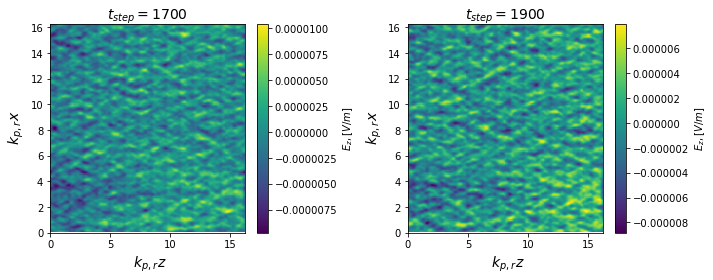

In [11]:
fig, (ax1, ax2) = plt.subplots( ncols=2, figsize=(10,4.) )

fs=14
cmap = "viridis"
aspect='auto'

img1 = ax1.imshow(Ez_start,aspect=aspect, cmap=cmap, extent=extent)
ax1.set_title('$t_{step}=$%i' % iteration_start, size=fs)
ax1.set_xlabel(' $k_{p,r} z$ ',size=fs)
ax1.set_ylabel(' $k_{p,r} x $ ',size=fs)
fig.colorbar(img1, ax=ax1, label = '$E_z, [V/m]$')

img2 = ax2.imshow(Ez_end,aspect=aspect, cmap=cmap, extent=extent)
ax2.set_title('$t_{step}=$%i' % iteration_end,size=fs)
ax2.set_xlabel(' $k_{p,r} z$ ',size=fs)
ax2.set_ylabel(' $k_{p,r} x $ ',size=fs)
fig.colorbar(img2, ax=ax2, label = '$E_z, [V/m]$')
plt.tight_layout()

/Users/oshapoval/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


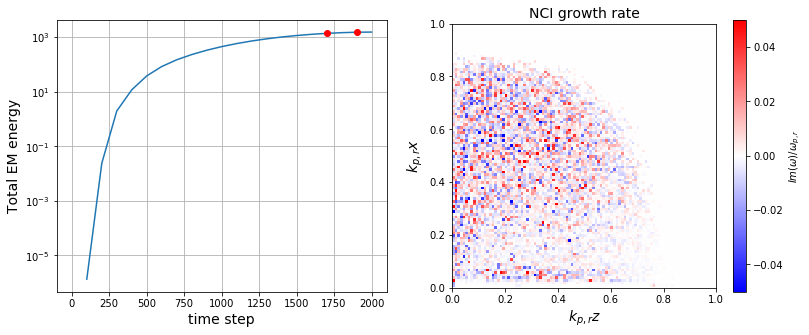

In [12]:
fig, (ax1, ax2) = plt.subplots( ncols=2,nrows=1, figsize=(13,5.) )

fs=14

img1 = ax1.semilogy(iterations_warpx,energy_list)
ax1.semilogy(iteration_start,energy_list[iteration_start/iter_delta],'ro')
ax1.semilogy(iteration_end,energy_list[iteration_end/iter_delta],'ro')
ax1.grid()
ax1.legend()
ax1.set_xlabel('time step',size=fs)
ax1.set_ylabel('Total EM energy',size=fs)

img2 = ax2.imshow( gr_wx, origin='lower' ,cmap='bwr', vmax=0.05, vmin=-vmax, interpolation='nearest', extent=[0, 1, 0, 1] )
ax2.set_title('NCI growth rate',size=fs)
ax2.set_xlabel('$k_{p,r} z$ ',size=fs)
ax2.set_ylabel('$k_{p,r} x $ ',size=fs)
fig.colorbar(img2, ax=ax2, label = '$Im(\omega)/\omega_{p,r}$')